### 参考： [源代码](https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch/tree/master/chapter5_RNN/time-series)
## 1. 读取数据集以及预处理

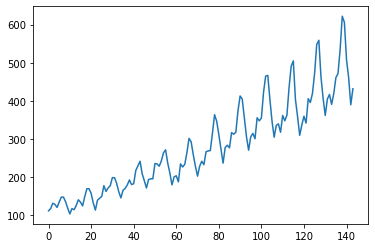

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_csv = pd.read_csv('./dataset/airplane_data.csv',usecols=[1])
plt.plot(data_csv)

In [42]:
# 首先我们进行预处理，将数据中 na 的数据去掉，然后将数据标准化到 0 ~ 1 之间。
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))  # dataset.shape = (144, )

## 2. 创建数据集
接着我们进行数据集的创建，我们想通过前面几个月的流量来预测当月的流量：  
- 比如我们希望通过前两个月的流量来预测当月的流量，我们可以将前两个月的流量当做输入，当月的流量当做输出。  
- 同时我们需要将我们的数据集分为训练集和测试集，通过测试集的效果来测试模型的性能。   
- 这里我们简单的将前面几年的数据作为训练集，后面两年的数据作为测试集。

In [43]:
# 这里的lookback表示用前两个月的流量预测当月流量
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i: (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 创建数据集以及打好标签
data_X, data_Y = create_dataset(dataset)

print("data_length:", len(data_X), len(data_Y))

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

data_length: 142 142


## 3. 改变维度
1. RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度
2. 这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.
3. 另外lstm结构中`input_size = 2`, `hidden_size = 4`

In [44]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

train_x shape: torch.Size([99, 1, 2])
train_y shape: torch.Size([99, 1, 1])


In [45]:
import torch.nn as nn

class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # LSTM
        self.reg = nn.Linear(hidden_size, output_size)          # regression

    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, hidden = x.shape
        x = x.view(-1, hidden)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [46]:
net = lstm_reg(2, 4)
print("model:", net)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

for e in range(1000):
    # 前向传播
    out = net(train_x)
    loss = criterion(out, train_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

model: lstm_reg(
  (rnn): LSTM(2, 4, num_layers=2)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 100, Loss: 0.00400
Epoch: 200, Loss: 0.00368
Epoch: 300, Loss: 0.00365
Epoch: 400, Loss: 0.00338
Epoch: 500, Loss: 0.00329
Epoch: 600, Loss: 0.00315
Epoch: 700, Loss: 0.00291
Epoch: 800, Loss: 0.00179
Epoch: 900, Loss: 0.00128
Epoch: 1000, Loss: 0.00103


## 4. 转换成测试模式
- 用训练好的模型预测测试集数据
- 画图表示，红线表示预测数据，蓝线表示测试集真实的数据

In [47]:
net = net.eval() 
test_X = torch.Tensor(test_X.reshape(-1, 1, 2))
pred_test_X = net(test_X)
pred_test_X = pred_test_X.view(-1).data.numpy()

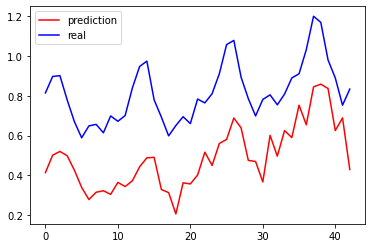

In [48]:
plt.plot(pred_test_X, 'r', label='prediction')
plt.plot(test_Y, 'b', label='real')
plt.legend(loc='best')

## 5. 总结
直接用75%的数据做训练预测后面25%的流量的结果图可以看出：不是那么准确，可能原因就是数据太少，毕竟只有144个月的数据